In [4]:
import numpy as np
from astropy.table import Table
import thecannon as tc
import matplotlib.pyplot as p

In [5]:
#paths
table_path = '/Users/catherinemanea/Documents/BP_RP/apogee_bprp_params/apogee_bprp_params/'
spec_path = '/Users/catherinemanea/Documents/BP_RP/apogee_bprp_params/apogee_bprp_params/' #assumes spec are in directory 'apogee' inside this path
fig_path = '/Users/catherinemanea/Documents/BP_RP/apogee_bprp_params/apogee_bprp_params/'

In [6]:
t = Table.read(table_path+'synth_apogee_0.fits')
t = t[t['synth']]

In [7]:
#loading in spec with max normalization
size = len(t) #adjust if you only want to play with subset of data

for i in range(size):
    if i%1000 == 0:
        print(np.round(100*i/size, 2), '%')
    Teff = t['Teff'][i] ; logg = t['logg'][i] ; feh = t['feh'][i] ;  a = t['A_v'][i] ; s = t['SNR'][i]
    filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff),str(logg),str(feh),str(a),str(s))
    try:
        w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
        wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
       
    except:  
        try:
            formatter = "{0:.12g}"
            Teff2 = formatter.format(Teff)
            logg2 = formatter.format(logg)
            feh2 = formatter.format(feh)
            s2 = formatter.format(s)
            a2 = formatter.format(a)
            filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff2),str(logg2),str(feh2),str(a2),str(s2))
            w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
            wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
            
        except:
            try:
                formatter = "{0:.12g}"
                logg2 = formatter.format(logg)
                feh2 = formatter.format(feh)
                s2 = formatter.format(s)
                a2 = formatter.format(a)
                filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff),str(logg2),str(feh2),str(a2),str(s2))
                w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
                wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
                
            except:
                formatter = "{0:.12g}"
                Teff2 = formatter.format(Teff)
                logg2 = formatter.format(logg)
                feh2 = formatter.format(feh)
                a2 = formatter.format(a)
                s = "{0:.1f}".format(s)
                filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff2),str(logg2),str(feh2),str(a2),str(s))
                w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
                wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)

    w = w[~np.isnan(ebp)]
    wr = wr[~np.isnan(erp)]
    fbp = fbp[~np.isnan(ebp)]
    ebp = ebp[~np.isnan(ebp)]
    frp = frp[~np.isnan(erp)]
    erp = erp[~np.isnan(erp)]
    
    if i == 0:
        xs = np.zeros((len(t[:size]),len(np.concatenate([fbp,frp]))))
        bps = np.zeros((len(t[:size]),len(fbp)))
        rps = np.zeros((len(t[:size]),len(frp)))
        xerrs = np.zeros((len(t[:size]),len(np.concatenate([fbp,frp]))))
        standard_errs = np.zeros((len(t[:size]),len(np.concatenate([fbp,frp]))))
    
    f = np.concatenate([fbp,frp])
    errs = 1.0/np.sqrt(np.concatenate([ebp,erp])/np.max(f))
    xs[i,:] = f/np.max(f)
    bps[i,:] = fbp/np.max(fbp)
    rps[i,:] = frp/np.max(frp)
    xerrs[i,:] = errs
    standard_errs[i,:] = np.concatenate([ebp,erp])/np.max(f)
    wf = np.concatenate([w,wr])
    

0.0 %
1.61 %
3.22 %
4.83 %
6.44 %
8.05 %
9.67 %
11.28 %
12.89 %
14.5 %
16.11 %
17.72 %
19.33 %
20.94 %
22.55 %
24.16 %
25.78 %
27.39 %
29.0 %
30.61 %
32.22 %
33.83 %
35.44 %
37.05 %
38.66 %
40.27 %
41.89 %
43.5 %
45.11 %
46.72 %
48.33 %
49.94 %
51.55 %
53.16 %
54.77 %
56.38 %
58.0 %
59.61 %
61.22 %
62.83 %
64.44 %
66.05 %
67.66 %
69.27 %
70.88 %
72.49 %
74.11 %
75.72 %
77.33 %
78.94 %
80.55 %
82.16 %
83.77 %
85.38 %
86.99 %
88.6 %
90.21 %
91.83 %
93.44 %
95.05 %
96.66 %
98.27 %
99.88 %


In [8]:
#making training and testing sets
# train_inds = np.random.choice(range(len(t)),int(.6*len(t)),replace=False)
# test_inds = np.array(list(set(range(len(t)))- set(train_inds)),dtype='int')
print(len(t))

np.random.seed(888) # For reproducibility.
q = np.random.randint(0, 10, len(t[:size])) % 10
validate_set = np.where((q<=1))[0]
train_set = np.where((q>1))[0]
train_inds = train_set
test_inds = validate_set

train_xs = xs[train_inds]
train_errs = xerrs[train_inds]
bad = np.where(np.isnan(train_xs))
train_xs[bad] = 0.0000001
bad = np.where(np.isnan(train_errs))
train_errs[bad] = 0.0000001
bad = np.where(train_xs==np.inf)
train_xs[bad] = 1e6
bad = np.where(train_errs==np.inf)
train_errs[bad] = 1e6

test_xs = xs[test_inds]
test_errs = xerrs[test_inds]
bad = np.where(np.isnan(test_xs))
test_xs[bad] = 0.0000001
bad = np.where(np.isnan(test_errs))
test_errs[bad] = 0.0000001
bad = np.where(test_xs==np.inf)
test_xs[bad] = 1e6
bad = np.where(test_errs==np.inf)
test_errs[bad] = 1e6

train_t = t[train_inds]
test_t = t[test_inds]

62074


(426,) (426,) (62074, 897)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


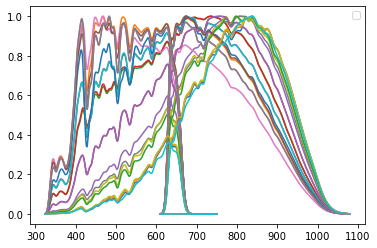

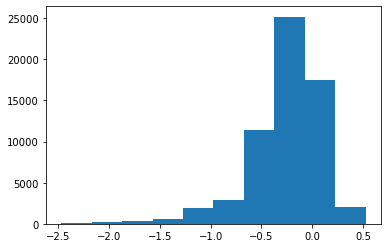

In [9]:
teffs = t['Teff']
loggs = t['logg']
fehs = t['feh']
avs = t['A_v']
snrs = t['SNR']

print(w.shape, fbp.shape, xs.shape)

p.figure()
N=1
for i in range(20):
    p.plot(wf, xs[i])
p.legend()
p.show()

p.figure()
p.hist(fehs)
p.show()

In [43]:
# Specify the vectorizer.
vectorizer = tc.vectorizer.PolynomialVectorizer(("Teff", "logg", "feh","A_v"), 2)
# set up model
model = tc.CannonModel(train_t, train_xs, train_errs,
                       vectorizer=vectorizer, dispersion=wf)


# Train the model!
model.train()



2022-05-25 08:53:21,591 [INFO] Training 4-label CannonModel with 49669 stars and 897 pixels/star
stty: 2022-05-25 08:53:21,678 [DEBUG] Couldn't get screen size. Progressbar may look odd.


[                                                                                                    ]   0% (3/897)                          

stdin isn't a terminal


[==================================                                                                  ]  30% (272/897)                          

2022-05-25 08:53:33,974 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  32% (286/897)                          

2022-05-25 08:53:34,920 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  32% (288/897)                          

2022-05-25 08:53:35,246 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  57% (515/897)                          

2022-05-25 08:53:42,418 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  58% (521/897)                          

2022-05-25 08:53:42,917 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  58% (523/897)                          

2022-05-25 08:53:43,257 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  62% (560/897)                          

2022-05-25 08:53:44,494 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  67% (601/897)                          

2022-05-25 08:53:46,195 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  68% (613/897)                          

2022-05-25 08:53:46,779 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  70% (630/897)                          

2022-05-25 08:53:47,438 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  72% (644/897)                          

2022-05-25 08:53:47,968 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  73% (658/897)                          

2022-05-25 08:53:48,499 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  74% (665/897)                          

2022-05-25 08:53:48,871 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  78% (703/897)                          

2022-05-25 08:53:49,848 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================================] 100% (32s)                              


(array([[ 5.78288738e-04,  1.13113163e-03,  9.05180636e-04, ...,
         -2.15880860e-05,  9.90018163e-05,  3.41932585e-05],
        [ 1.12283553e-03,  2.24504411e-03,  1.74541485e-03, ...,
         -1.09870768e-04,  1.79330251e-04,  6.36430066e-05],
        [ 2.06768368e-03,  4.16955652e-03,  3.17772833e-03, ...,
         -2.34960684e-04,  3.52782459e-04,  1.12225260e-04],
        ...,
        [ 3.98196206e-04, -3.79149548e-04,  4.79237797e-05, ...,
         -1.11762781e-04,  8.60914955e-04,  1.52435997e-04],
        [ 3.43782421e-04, -2.68791577e-04,  6.22366061e-06, ...,
         -6.13567566e-05,  8.04316736e-04,  7.71795456e-06],
        [ 2.82231761e-04, -1.90346401e-05, -1.10552738e-04, ...,
         -1.35398434e-06,  3.77309696e-04, -1.20532588e-04]]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.000

In [36]:
# from multiprocessing import Pool
# pool = Pool()

In [38]:
# res = pool.apply_async(model.test, [test_xs[:10], test_errs[:10]])


Process SpawnPoolWorker-93:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/anaconda3/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
  File "/opt/anaconda3/lib/python3.9/site-packages/thecannon/vectorizer/base.py", line 51, in __setstate__
    model_name, kwds = kwds
UnboundLocalError: local variable 'kwds' referenced before assignment


In [44]:
#infer for train
test_labels, cov, metadata = model.test(test_xs, test_errs, threads=1)

#fig_comparison = tc.plot.one_to_one(model, test_labels, latex_label_names=[r"T_{\rm eff}",r"\log{g}",r"[{\rm Fe}/{\rm H}]",r"{\rm A_V}"])
#fig_comparison.savefig(fig_path+"one-to-one.png", dpi=300)

stty: stdin isn't a terminal2022-05-25 08:53:54,255 [DEBUG] Couldn't get screen size. Progressbar may look odd.

2022-05-25 08:53:54,257 [INFO] Running test step on 12405 spectra


[====================================================================================================] 100% (177s)                                 


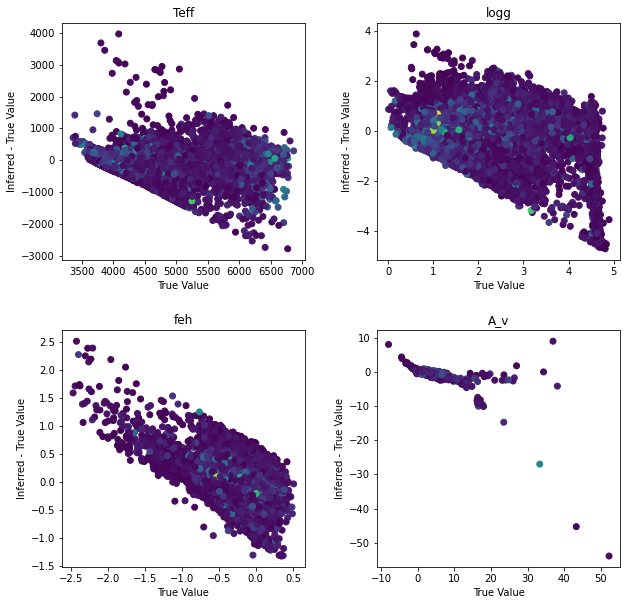

In [47]:
fig, axs = p.subplots(2,2,figsize=(10,10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i, param in enumerate(['Teff', 'logg', 'feh', 'A_v']):
    ax = np.ravel(axs)[i]
    ax.scatter(t[param][test_inds],test_labels[:,i] - t[param][test_inds],c=t['SNR'][test_inds])
    ax.set_title(param)
    ax.set_xlabel("True Value")
    ax.set_ylabel("Inferred - True Value")

In [51]:
print(np.mean(test_labels[:,0]))
print(np.mean(np.abs(test_labels[:,0]-t['Teff'][test_inds])))
print(np.mean(np.abs(test_labels[:,1]-t['logg'][test_inds])))
print(np.mean(t['Teff'][test_inds]))

4738.856386230327
351.58016623076395
0.980726118463609
4864.145472623186


In [46]:
print(np.min(t['Teff'][test_inds]), np.max(t['Teff'][test_inds]))
print(np.min(t['Teff'][train_inds]), np.max(t['Teff'][train_inds]))

3358.777099609375 6866.439453125
3236.025146484375 6885.6650390625
